##Import your libraries for sentiment analysis

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!python -m nltk.downloader punkt
!pip install pandas
!pip install pyLDAvis
!pip install sklearn
!pip install gensim

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
 

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import string
import re
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import networkx as nx

import gensim
from gensim.utils import simple_preprocess
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Load your scrapped Data

In [ ]:
import pandas as pd
try:
    df = pd.read_csv('/content/combined_comments.csv')
    #df2 = pd.read_csv('/content/ETN.csv')
    #df3 = pd.read_csv('/content/GE.csv')

    # Concatenate the dataframes
    #df = pd.concat([df1], ignore_index=True)

    # Print some info about the concatenated dataframe (optional)
    print(df.info())

except FileNotFoundError:
    print("One or more data files not found. Please check the filenames and paths.")
except pd.errors.EmptyDataError:
    print("One or more data files are empty.")
except Exception as e:
    print(f"An error occurred: {e}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2663 entries, 0 to 2662
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2662 non-null   object
 1   Comment      2663 non-null   object
 2   Time         2663 non-null   object
 3   Likes        2663 non-null   object
 4   Reply Count  1488 non-null   object
dtypes: object(5)
memory usage: 104.2+ KB
None


In [ ]:
df.head()

,Name,Comment,Time,Likes,Reply Count
0,@alexandrekirouac5921,3.4 trillion dollars trade market is not the b...,2025-07-06T16:28:12Z,0,0
1,@bernardsabiti5419,An incredibly well done docu.,2025-07-04T18:42:49Z,0,0
2,@CH-km5il,That is due to exploitation of African resourc...,2025-07-03T12:43:52Z,0,0
3,@psikeyhackr6914,As long as people believe in the Planned Obsol...,2025-07-03T04:46:01Z,0,0
4,@martin4819,I don’t have much hope for Africa. Young worki...,2025-07-02T20:32:46Z,0,0


In [ ]:
#df = pd.read_csv("/content/Manufacturing.csv")
#df.head()

In [ ]:
df['Comment'].nunique()

2626

##Load Stopwords

In [ ]:
# Load stop words
stop_words = stopwords.words('english')

# Show stop words
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

##Perform data cleaning by removing hastags, urls, mentions, symbols, www, pictures, emoji, etc

In [ ]:

# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """
    tweets cleaning by
    1) lowering the case of the tweet,
    2) removing unwanted symbols and replacing them with a whitespace,
    3) split sentences into words according to whitespaces and then
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text)) # remove @mentions
    text = re.sub(r'#', '',  str(text)) # remove the '#' symbol
    text = re.sub(r'RT[\s]+', '',  str(text)) # remove RT
    text = re.sub(r'https?\/\/S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'http\S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'www\S+', '',  str(text)) # remove the www
    text = re.sub(r'pic+', '',  str(text)) # remove the pic
    text = re.sub(r'com', '',  str(text)) # remove the pic
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string):
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string i.e. remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')

In [ ]:
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [ ]:
# removing useless content (hashtags, mentions)
df['Comment'].apply(str)

,Comment
0,3.4 trillion dollars trade market is not the b...
1,An incredibly well done docu.
2,That is due to exploitation of African resourc...
3,As long as people believe in the Planned Obsol...
4,I don’t have much hope for Africa. Young worki...
...,...
2658,Thanks for the support @jama abdishakur! I bel...
2659,They call it the gateway to Africa..#Africaisr...
2660,EXACTLY my brethren. We need an army in every ...
2661,Not only that to expand my empire into africa.


In [ ]:
df['cleaned_comments'] = df['Comment'].astype(str).apply(lambda x: process_tweet(x))

In [ ]:
df

,Name,Comment,Time,Likes,Reply Count,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,@alexandrekirouac5921,3.4 trillion dollars trade market is not the b...,2025-07-06T16:28:12Z,0,0,3 4 trillion dollars trade market is not the b...,0.000000,0.000000,Neutral,Fact,Neutral Fact
1,@bernardsabiti5419,An incredibly well done docu.,2025-07-04T18:42:49Z,0,0,an incredibly well done docu,0.900000,0.900000,Positive,Opinion,Positive Opinion
2,@CH-km5il,That is due to exploitation of African resourc...,2025-07-03T12:43:52Z,0,0,that is due to exploitation of african resourc...,0.158333,-0.041667,Negative,Opinion,Negative Opinion
3,@psikeyhackr6914,As long as people believe in the Planned Obsol...,2025-07-03T04:46:01Z,0,0,as long as people believe in the planned obsol...,0.160185,0.025000,Positive,Opinion,Positive Opinion
4,@martin4819,I don’t have much hope for Africa. Young worki...,2025-07-02T20:32:46Z,0,0,i don t have much hope for africa young workin...,0.544655,0.096059,Positive,Opinion,Positive Opinion
...,...,...,...,...,...,...,...,...,...,...,...
2658,@RisenAfrica,Thanks for the support @jama abdishakur! I bel...,2021-01-02T20:21:43Z,8,NaN,thanks for the support abdishakur i believe so...,0.600000,0.400000,Positive,Opinion,Positive Opinion
2659,@AA-mw8dt,They call it the gateway to Africa..#Africaisr...,2021-01-04T22:43:45Z,1,NaN,they call it the gateway to africa africaisrising,0.000000,0.000000,Neutral,Fact,Neutral Fact
2660,@kingofhearts1072,EXACTLY my brethren. We need an army in every ...,2021-01-05T05:37:34Z,1,NaN,exactly my brethren we need an army in every n...,0.583333,0.383333,Positive,Opinion,Positive Opinion
2661,@anti-matter5874,Not only that to expand my empire into africa.,2021-01-07T04:34:41Z,1,NaN,not only that to expand my empire into africa,1.000000,0.000000,Neutral,Opinion,Neutral Opinion


###Check the number of comments or reviews in the dataset

In [ ]:
df['cleaned_comments'].nunique()

2565

In [ ]:
#Save cleaned_comments data
df.to_csv('cleaned_comments.csv', index=False)

In [ ]:
df['Comment'] = df['Comment'].str.replace('http\S+', '')


<>:1: DeprecationWarning: invalid escape sequence '\S'
<>:1: DeprecationWarning: invalid escape sequence '\S'
/tmp/ipython-input-47-2199923037.py:1: DeprecationWarning: invalid escape sequence '\S'
  df['Comment'] = df['Comment'].str.replace('http\S+', '')


###Generate Word Frequency to analyze the most occuring word within the dataset

In [ ]:
from PIL import Image
import urllib
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

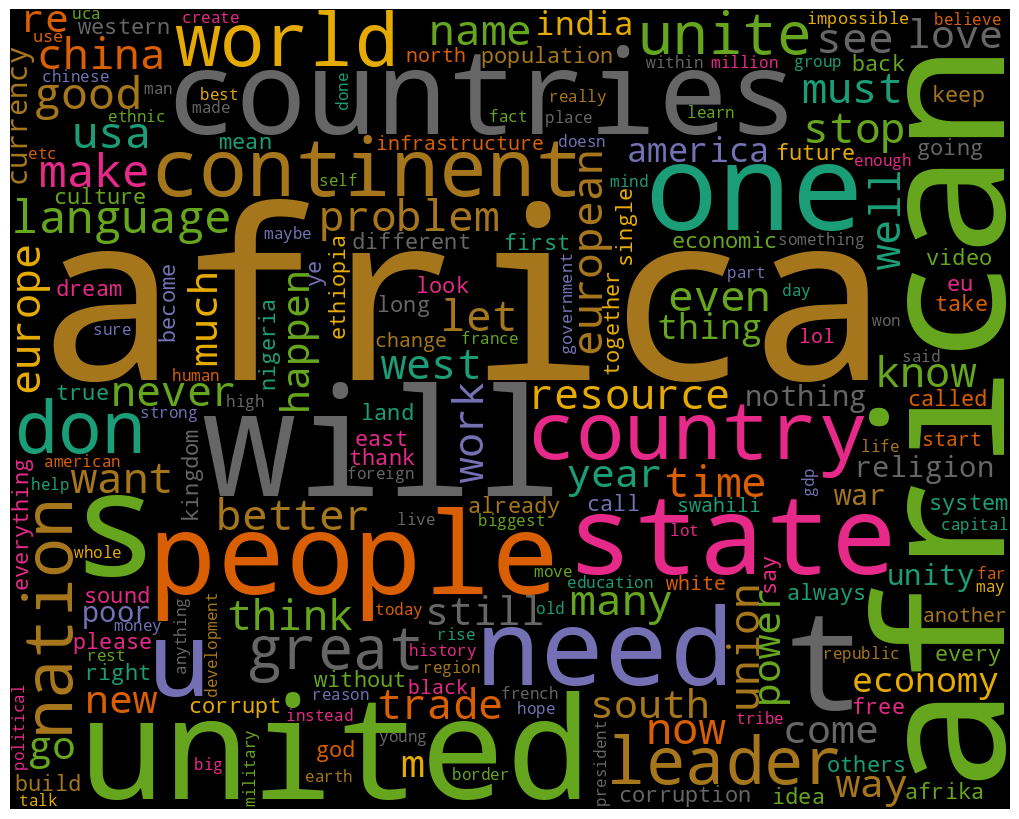

In [ ]:
comment_words = []
stopwords = set(STOPWORDS)

# iterate through the cleaned_comments
for val in df.cleaned_comments:
    # typecaste each val to string
    val = str(val)

    # split the value into tokens
    tokens = val.split()

    # Converts each token into lowercase
    cleaned_tokens = [token.lower() for token in tokens]

    # Append the list of tokens for this comment to comment_words
    comment_words.append(cleaned_tokens)

# The rest of your code for generating and plotting the WordCloud
comment_words_str = " ".join([" ".join(tokens) for tokens in comment_words])

wordcloud = WordCloud(width = 1000, height = 800,
                background_color='black', colormap='Dark2',
                collocations=False,
                stopwords = stopwords,
                min_font_size = 12).generate(comment_words_str)

# plot the WordCloud image
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###Plot Polarity and Subjectivity Scores

In [ ]:
from textblob import TextBlob
def getSubjectivity(text):
    return TextBlob( str(text)).sentiment.subjectivity

def getPolarity(text):
    return TextBlob( str(text)).sentiment.polarity

In [ ]:
df.dropna(subset=['cleaned_comments'], inplace = True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['Subjectivity'] = df['cleaned_comments'].apply(getSubjectivity)
df['Polarity'] = df['cleaned_comments'].apply(getPolarity)
df.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,@alexandrekirouac5921,3.4 trillion dollars trade market is not the b...,2025-07-06T16:28:12Z,0,0,3 4 trillion dollars trade market is not the b...,0.000000,0.000000,Neutral,Fact,Neutral Fact
1,@bernardsabiti5419,An incredibly well done docu.,2025-07-04T18:42:49Z,0,0,an incredibly well done docu,0.900000,0.900000,Positive,Opinion,Positive Opinion
2,@CH-km5il,That is due to exploitation of African resourc...,2025-07-03T12:43:52Z,0,0,that is due to exploitation of african resourc...,0.158333,-0.041667,Negative,Opinion,Negative Opinion
3,@psikeyhackr6914,As long as people believe in the Planned Obsol...,2025-07-03T04:46:01Z,0,0,as long as people believe in the planned obsol...,0.160185,0.025000,Positive,Opinion,Positive Opinion
4,@martin4819,I don’t have much hope for Africa. Young worki...,2025-07-02T20:32:46Z,0,0,i don t have much hope for africa young workin...,0.544655,0.096059,Positive,Opinion,Positive Opinion


In [ ]:

def get_Polarity_Analysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'
def get_Subjectivity_Analysis(score):
    if score >  0:
      return 'Opinion'
    else:
      return 'Fact'

df['Analysis_Polarity'] = df['Polarity'].apply(get_Polarity_Analysis)

df['Analysis_Subjectivity'] = df['Subjectivity'].apply(get_Subjectivity_Analysis)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)

###Plot Polarity and Subjectiviy Score in Scatter Plot

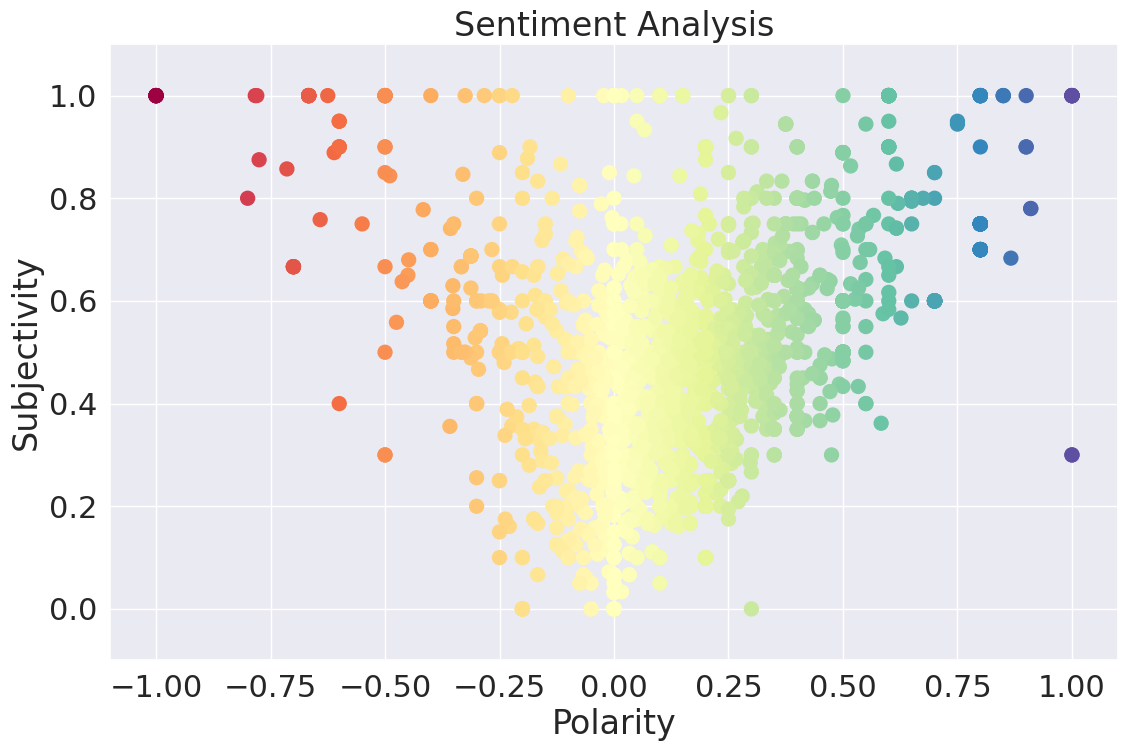

(None,)

In [ ]:
plt.figure(figsize=(13,8))

plt.scatter(df['Polarity'], df['Subjectivity'], c=df['Polarity'], s=100, cmap='Spectral')

plt.xlim(-1.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show(),

In [ ]:
df['Sentiment'] = df.apply(lambda x: ' '.join([str(x['Analysis_Polarity']),str(x['Analysis_Subjectivity'])]),axis=1)
df.head()


,Name,Comment,Time,Likes,Reply Count,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,@alexandrekirouac5921,3.4 trillion dollars trade market is not the b...,2025-07-06T16:28:12Z,0,0,3 4 trillion dollars trade market is not the b...,0.000000,0.000000,Neutral,Fact,Neutral Fact
1,@bernardsabiti5419,An incredibly well done docu.,2025-07-04T18:42:49Z,0,0,an incredibly well done docu,0.900000,0.900000,Positive,Opinion,Positive Opinion
2,@CH-km5il,That is due to exploitation of African resourc...,2025-07-03T12:43:52Z,0,0,that is due to exploitation of african resourc...,0.158333,-0.041667,Negative,Opinion,Negative Opinion
3,@psikeyhackr6914,As long as people believe in the Planned Obsol...,2025-07-03T04:46:01Z,0,0,as long as people believe in the planned obsol...,0.160185,0.025000,Positive,Opinion,Positive Opinion
4,@martin4819,I don’t have much hope for Africa. Young worki...,2025-07-02T20:32:46Z,0,0,i don t have much hope for africa young workin...,0.544655,0.096059,Positive,Opinion,Positive Opinion


In [ ]:
#Save cleaned_comments data
df.to_csv('scores.csv', index=False)
from google.colab import files

files.download('scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Plot Polarity Score for the entire dataset using bar chart

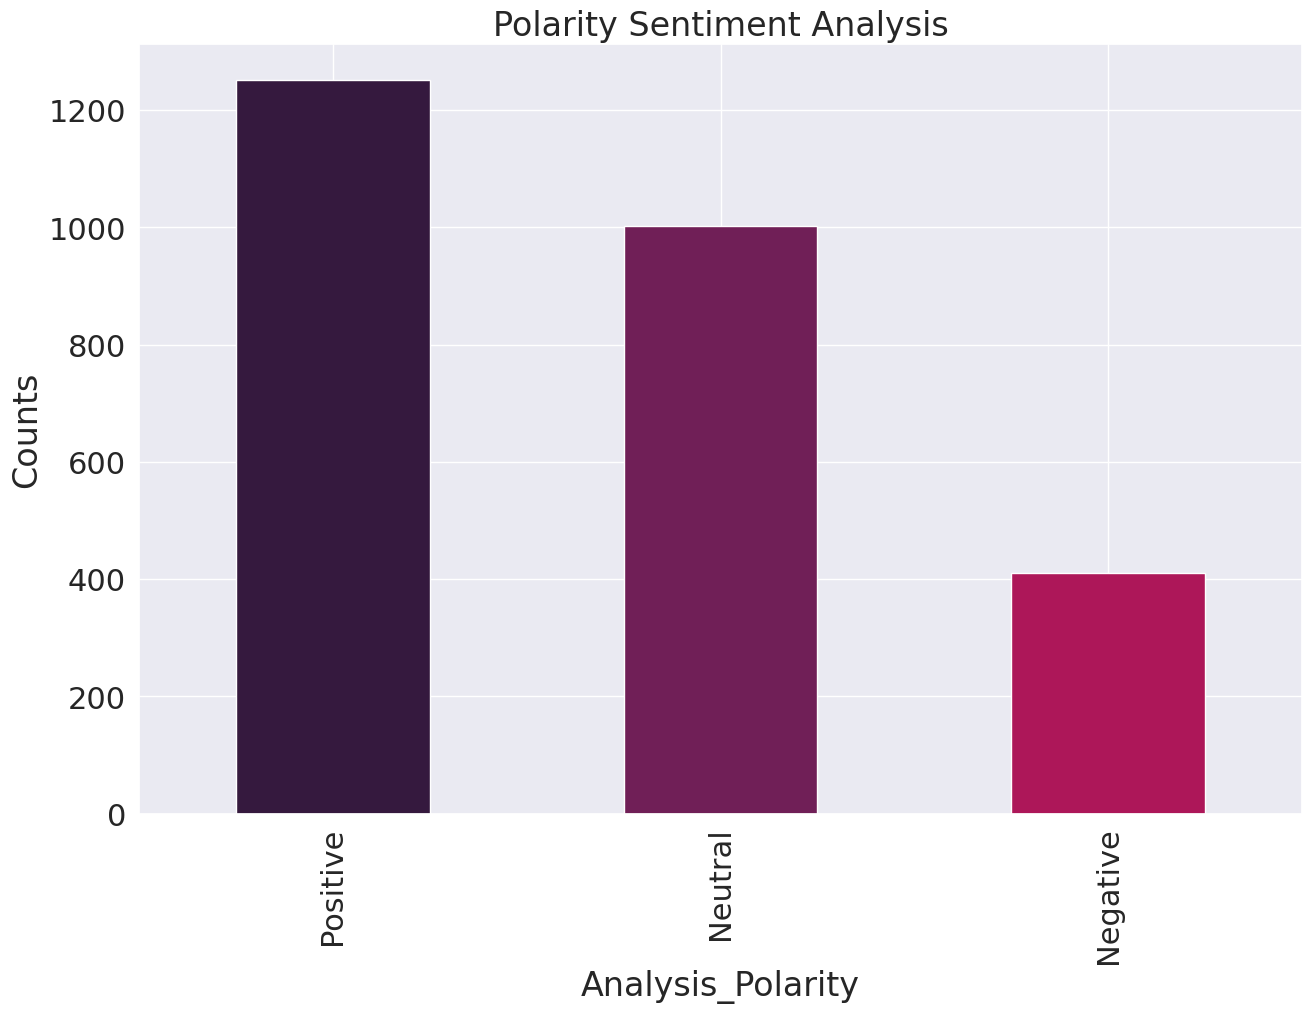

In [ ]:

plt.figure(figsize=(15,10))

plt.title('Polarity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Polarity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()

###Plot Subjectivity and Objective

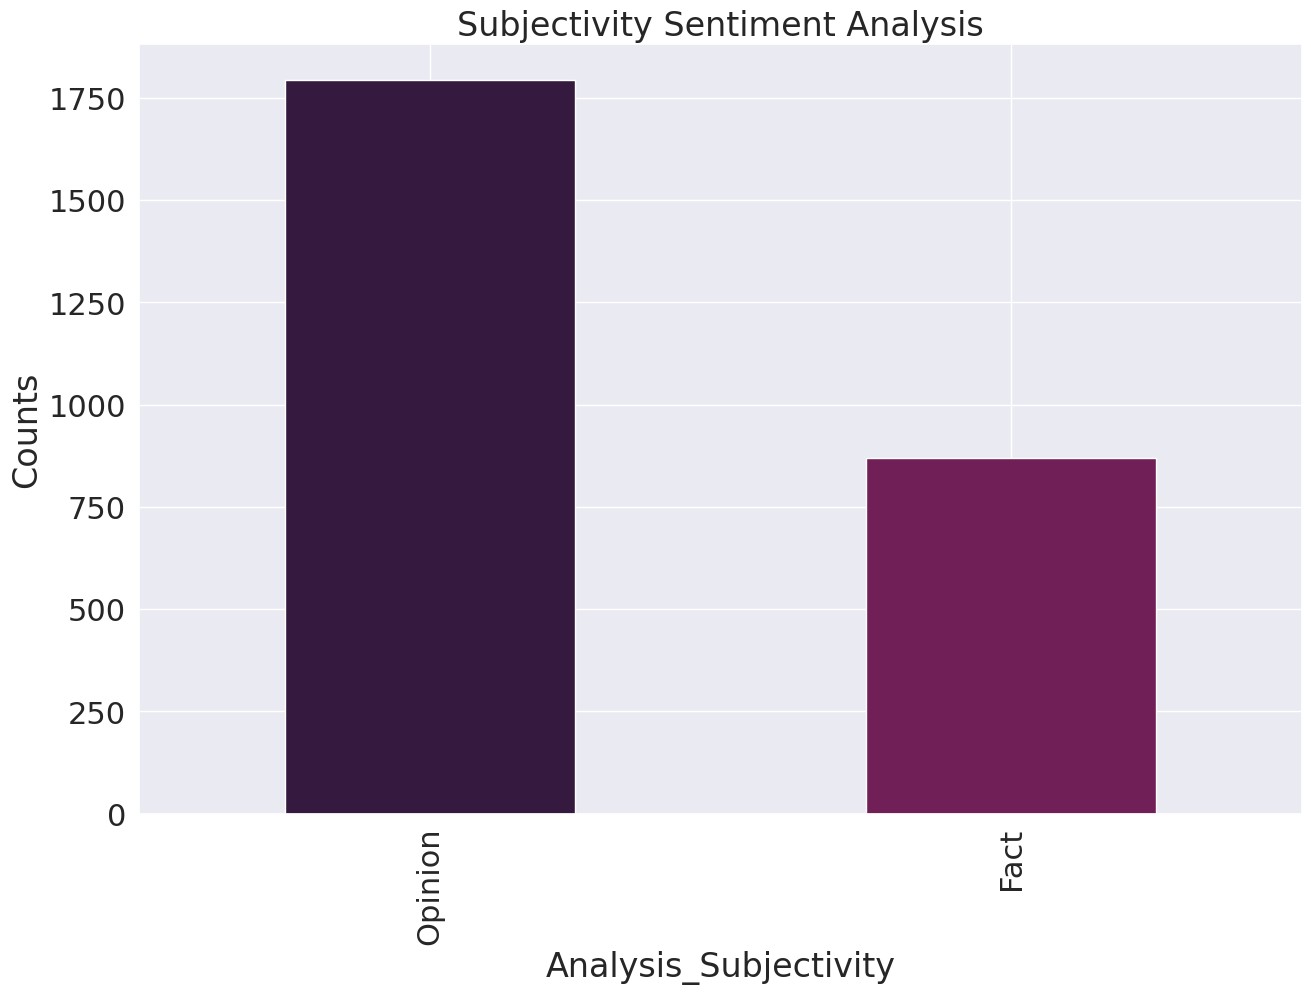

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Subjectivity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Subjectivity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()


In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tf.shape)

(2663, 543)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tfidf.shape)

(2663, 543)


In [ ]:
# for TF DTM
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=50)

In [ ]:
import pyLDAvis.lda_model
...
pyLDAvis.lda_model.prepare

<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [ ]:
import gensim.corpora as corpora

# Create Dictionary.
id2word = corpora.Dictionary(comment_words)

# Create Corpus.
texts = comment_words

# Term Document Frequency.
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
from pprint import pprint

# Number of topics.
num_topics = 10

# Build LDA model.
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics
)

# Print the Keyword in the 10 topics.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"of" + 0.026*"you" + 0.026*"africa" + 0.020*"and" + 0.015*"united" + '
  '0.014*"a" + 0.013*"is" + 0.012*"the" + 0.011*"to" + 0.010*"i"'),
 (1,
  '0.030*"of" + 0.026*"a" + 0.025*"the" + 0.018*"africa" + 0.015*"are" + '
  '0.014*"it" + 0.014*"be" + 0.013*"and" + 0.013*"is" + 0.011*"you"'),
 (2,
  '0.032*"the" + 0.030*"to" + 0.020*"we" + 0.020*"and" + 0.019*"of" + '
  '0.018*"that" + 0.016*"africa" + 0.015*"is" + 0.014*"not" + 0.012*"in"'),
 (3,
  '0.053*"the" + 0.027*"of" + 0.020*"and" + 0.018*"to" + 0.015*"africa" + '
  '0.015*"in" + 0.012*"i" + 0.011*"a" + 0.011*"are" + 0.011*"that"'),
 (4,
  '0.031*"to" + 0.028*"the" + 0.023*"and" + 0.021*"is" + 0.018*"it" + '
  '0.015*"that" + 0.014*"a" + 0.013*"africa" + 0.013*"i" + 0.013*"you"'),
 (5,
  '0.057*"the" + 0.032*"of" + 0.026*"and" + 0.025*"to" + 0.018*"it" + '
  '0.017*"a" + 0.015*"is" + 0.012*"africa" + 0.012*"in" + 0.009*"you"'),
 (6,
  '0.050*"the" + 0.031*"to" + 0.023*"is" + 0.021*"of" + 0.021*"africa" + '
  '0.017*"a

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

# Visualize the topics.
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f'cleaned_comments_lda_{num_topics}.data')

if os.path.exists(LDAvis_data_filepath):
    # Load the pre-prepared pyLDAvis data from disk.
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
else:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

pyLDAvis.save_html(LDAvis_prepared, f'{LDAvis_data_filepath}.html')

In [ ]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.003801  0.066613       1        1  21.873013
8      0.039093  0.003796       2        1  11.374970
7     -0.001459  0.000149       3        1  10.591944
4      0.051597  0.043514       4        1   9.452641
6      0.059119  0.046586       5        1   9.379643
5      0.035555 -0.040624       6        1   8.783157
9     -0.026156  0.044161       7        1   8.340552
3     -0.170063  0.008219       8        1   7.329780
0     -0.003411 -0.042544       9        1   7.201371
1      0.011924 -0.129871      10        1   5.672928, topic_info=        Term        Freq       Total Category  logprob  loglift
214      nan  136.000000  136.000000  Default  30.0000  30.0000
1543      ge  408.000000  408.000000  Default  29.0000  29.0000
472      est   92.000000   92.000000  Default  28.0000  28.0000
127    today  169.000000  169.000000  Default  27.0000  27.0000
4097     sec   73.000000   73.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1543      ge    8.780963  408.360740  Topic10  -5.4474  -0.9701
169       go    6.278052   55.456752  Topic10  -5.7830   0.6909
2746  system    6.172303   65.371475  Topic10  -5.8000   0.5095
507   stocks    6.230935   72.398360  Topic10  -5.7905   0.4168
1        buy    6.205342  176.383107  Topic10  -5.7946  -0.4778

[810 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4570      7  0.832623  ackman
413       1  0.045397  active
413       2  0.453967  active
413       3  0.136190  active
413       6  0.045397  active
...     ...       ...     ...
1213      2  0.264604     yoy
1213      3  0.110252     yoy
1213      4  0.308705     yoy
1213      5  0.044101     yoy
1213      9  0.022050     yoy

[2356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 8, 5, 7, 6, 10, 4, 1, 2])

In [ ]:
topic_values = lda_tf.transform(dtm_tf)
topic_values.shape

(2663, 10)

In [ ]:
df.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,@alexandrekirouac5921,3.4 trillion dollars trade market is not the b...,2025-07-06T16:28:12Z,0,0,3 4 trillion dollars trade market is not the b...,0.000000,0.000000,Neutral,Fact,Neutral Fact
1,@bernardsabiti5419,An incredibly well done docu.,2025-07-04T18:42:49Z,0,0,an incredibly well done docu,0.900000,0.900000,Positive,Opinion,Positive Opinion
2,@CH-km5il,That is due to exploitation of African resourc...,2025-07-03T12:43:52Z,0,0,that is due to exploitation of african resourc...,0.158333,-0.041667,Negative,Opinion,Negative Opinion
3,@psikeyhackr6914,As long as people believe in the Planned Obsol...,2025-07-03T04:46:01Z,0,0,as long as people believe in the planned obsol...,0.160185,0.025000,Positive,Opinion,Positive Opinion
4,@martin4819,I don’t have much hope for Africa. Young worki...,2025-07-02T20:32:46Z,0,0,i don t have much hope for africa young workin...,0.544655,0.096059,Positive,Opinion,Positive Opinion


In [ ]:
df_1=df.replace({0: 'African Unity',1: 'Future Vision', 2:'Collective Doubt', 3: 'Individual Views', 4:'Public Dialogue', 5:'Implementation Concerns', 6:'Policy Advocacy', 7:'Hopeful Outlook', 8:'Empowerment', 9:'Shared Responsibility'})

In [ ]:
df_1['topic'] = topic_values.argmax(axis=1)

In [ ]:
df['Topic'] = topic_values.argmax(axis=1)

In [ ]:
df_1.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic,topic
0,@alexandrekirouac5921,3.4 trillion dollars trade market is not the b...,2025-07-06T16:28:12Z,0,0,3 4 trillion dollars trade market is not the b...,African Unity,African Unity,Neutral,Fact,Neutral Fact,Shared Responsibility,9
1,@bernardsabiti5419,An incredibly well done docu.,2025-07-04T18:42:49Z,0,0,an incredibly well done docu,0.9,0.9,Positive,Opinion,Positive Opinion,African Unity,0
2,@CH-km5il,That is due to exploitation of African resourc...,2025-07-03T12:43:52Z,0,0,that is due to exploitation of african resourc...,0.158333,-0.041667,Negative,Opinion,Negative Opinion,Empowerment,8
3,@psikeyhackr6914,As long as people believe in the Planned Obsol...,2025-07-03T04:46:01Z,0,0,as long as people believe in the planned obsol...,0.160185,0.025,Positive,Opinion,Positive Opinion,Empowerment,8
4,@martin4819,I don’t have much hope for Africa. Young worki...,2025-07-02T20:32:46Z,0,0,i don t have much hope for africa young workin...,0.544655,0.096059,Positive,Opinion,Positive Opinion,Public Dialogue,4


In [ ]:
df_1.columns

Index(['Name', 'Comment', 'Time', 'Likes', 'Reply Count', 'cleaned_comments',
       'Subjectivity', 'Polarity', 'Analysis_Polarity',
       'Analysis_Subjectivity', 'Sentiment', 'Topic', 'topic'],
      dtype='object')

<Figure size 4000x2500 with 0 Axes>

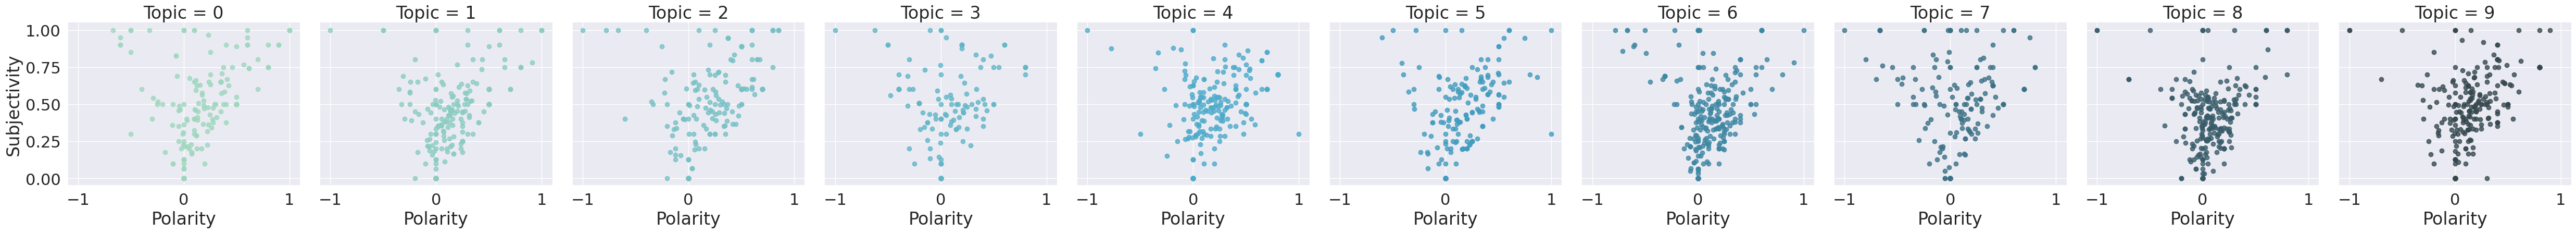

In [ ]:
plt.figure(figsize=(40,25))

g=sns.lmplot(x="Polarity", y="Subjectivity", hue='Topic', data=df, fit_reg=False, legend=False,palette="GnBu_d", col='Topic', legend_out=True)


plt.show()

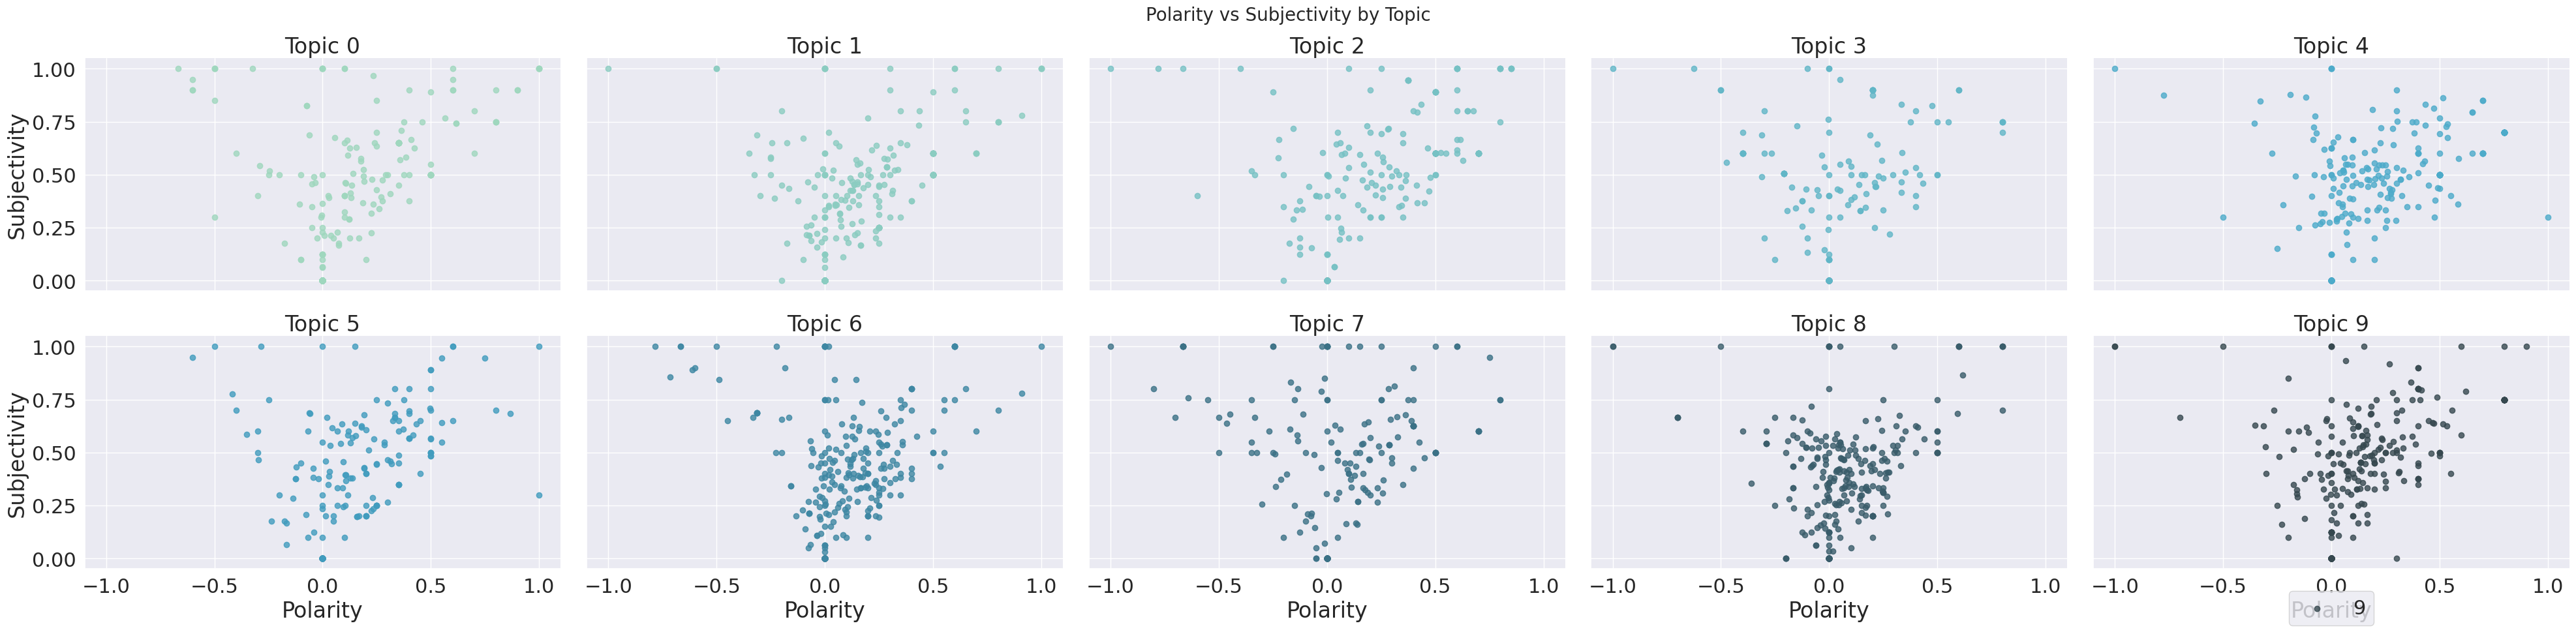

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.lmplot(
    x="Polarity",
    y="Subjectivity",
    hue="Topic",
    data=df,
    fit_reg=False,
    legend=False,
    palette="GnBu_d",
    col="Topic",
    col_wrap=5,        # 5 columns → 2 rows for 10 topics
    height=5,          # controls row height
    aspect=1.6         # controls column width (height × aspect = width per subplot)
)

g.set_titles("Topic {col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Polarity vs Subjectivity by Topic", fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.show()


In [ ]:
df_2 = df_1.groupby(['Topic'])['Analysis_Polarity'].value_counts().unstack('Topic').transpose()

df_2

Analysis_Polarity,Negative,Neutral,Positive
Topic,,,
African Unity,33,227,107
Collective Doubt,28,50,130
Empowerment,73,74,145
Future Vision,35,187,133
Hopeful Outlook,54,72,87
Implementation Concerns,29,64,114
Individual Views,43,59,59
Policy Advocacy,50,93,158
Public Dialogue,28,59,160


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, African Unity to Shared Responsibility
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Negative  10 non-null     int64
 1   Neutral   10 non-null     int64
 2   Positive  10 non-null     int64
dtypes: int64(3)
memory usage: 320.0+ bytes


In [ ]:
df_2['Total'] = df_2.sum(axis=1)

In [ ]:
df_2.columns

Index(['Negative', 'Neutral', 'Positive', 'Total'], dtype='object', name='Analysis_Polarity')

In [ ]:
for i in df_2:
    df_2[i] = round(df_2[i]*100/df_2.Total)

df_2

Analysis_Polarity,Negative,Neutral,Positive,Total
Topic,,,,
African Unity,9.0,62.0,29.0,100.0
Collective Doubt,13.0,24.0,62.0,100.0
Empowerment,25.0,25.0,50.0,100.0
Future Vision,10.0,53.0,37.0,100.0
Hopeful Outlook,25.0,34.0,41.0,100.0
Implementation Concerns,14.0,31.0,55.0,100.0
Individual Views,27.0,37.0,37.0,100.0
Policy Advocacy,17.0,31.0,52.0,100.0
Public Dialogue,11.0,24.0,65.0,100.0


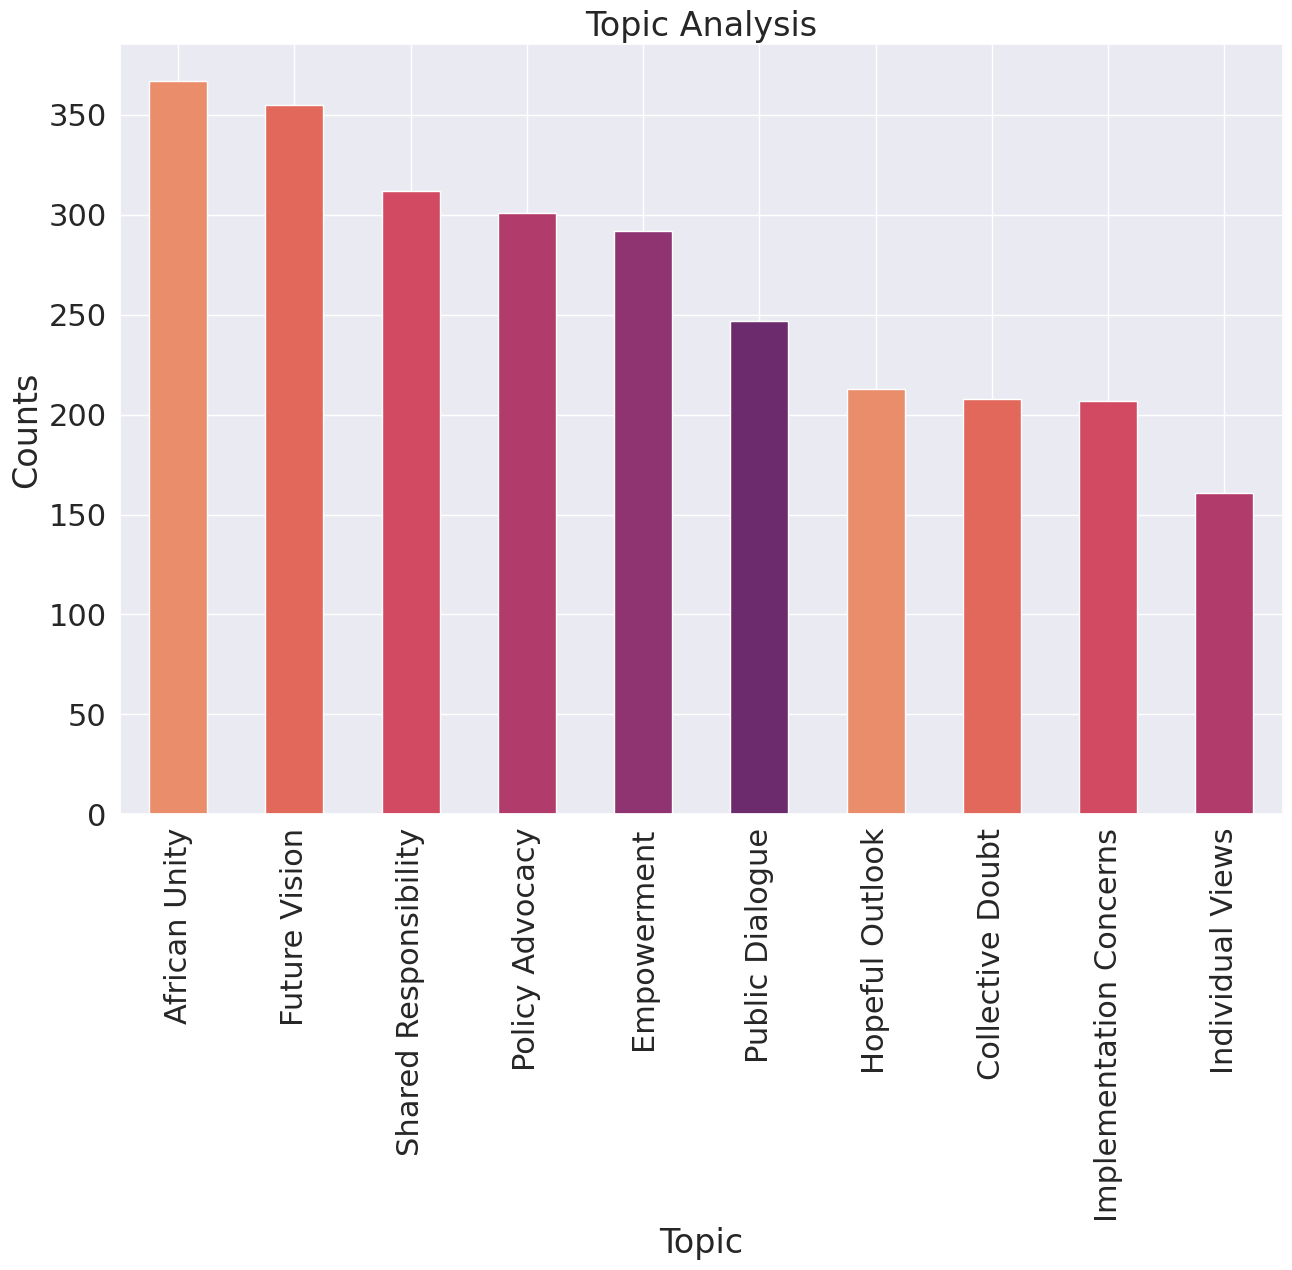

In [ ]:
# Plot and visualizing the counts for each topic
plt.figure(figsize=(15,10))

plt.title('Topic Analysis')
plt.xlabel('Topic')
plt.ylabel('Counts')
df_1['Topic'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('flare'))
plt.show()


In [ ]:
df_2=df_2.fillna(0)

In [ ]:
df_2['Total'] = df_2.sum(axis=1)
df_2 = df_2.drop(['Total'], axis=1)

In [ ]:
print(df_2.shape)

(10, 3)


In [ ]:
print(df_2.head())

Analysis_Polarity  Negative  Neutral  Positive
Topic                                         
African Unity           9.0     62.0      29.0
Collective Doubt       13.0     24.0      62.0
Empowerment            25.0     25.0      50.0
Future Vision          10.0     53.0      37.0
Hopeful Outlook        25.0     34.0      41.0


In [ ]:
print(df_2.tail())

Analysis_Polarity        Negative  Neutral  Positive
Topic                                               
Implementation Concerns      14.0     31.0      55.0
Individual Views             27.0     37.0      37.0
Policy Advocacy              17.0     31.0      52.0
Public Dialogue              11.0     24.0      65.0
Shared Responsibility        12.0     38.0      51.0


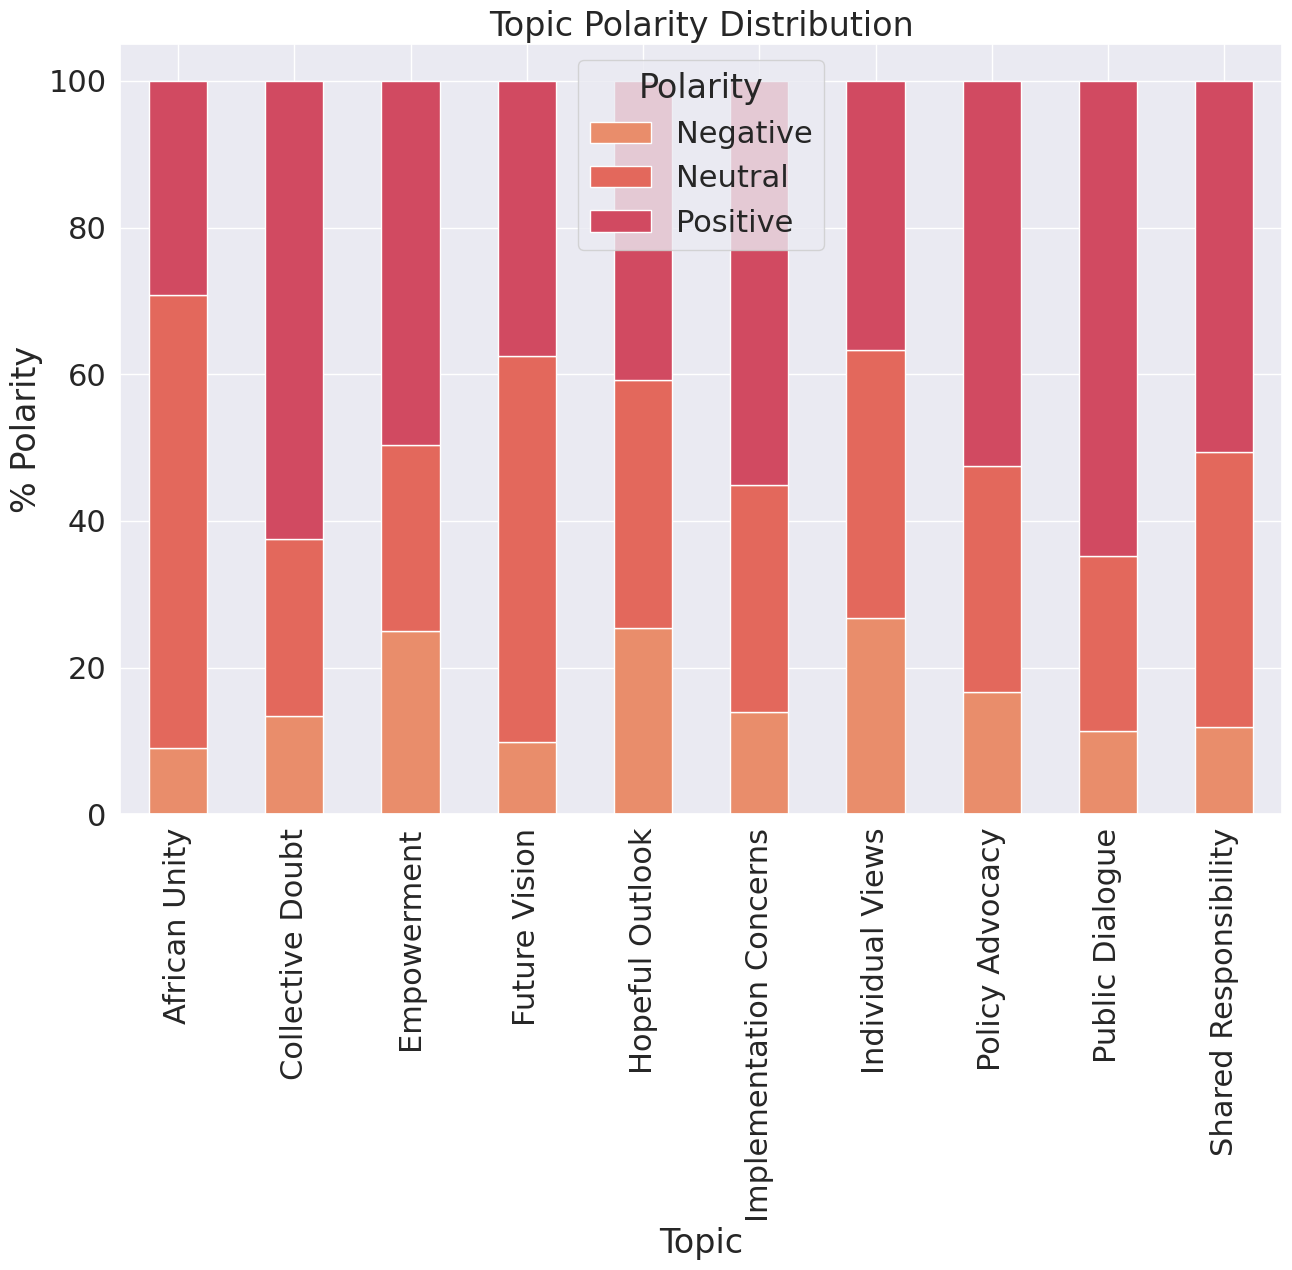

In [ ]:
# Create a new dataframe with topic names and polarity percentages
df_topic_polarity = df_1.groupby('Topic')['Analysis_Polarity'].value_counts().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Create the stacked bar plot
ax = df_topic_polarity.plot(kind='bar',color=sns.palettes.mpl_palette('flare'), stacked=True, figsize=(15, 10))

# Add labels and title
ax.set_xlabel('Topic')
ax.set_ylabel('% Polarity')
ax.set_title('Topic Polarity Distribution')

# Add topic names to the x-axis
ax.set_xticklabels(df_topic_polarity.index, rotation=90)

# Add legend
ax.legend(title='Polarity')

# Show the plot
plt.show()


###Perform Topic Labeling to analyze the polarity score of each of the topics identified.

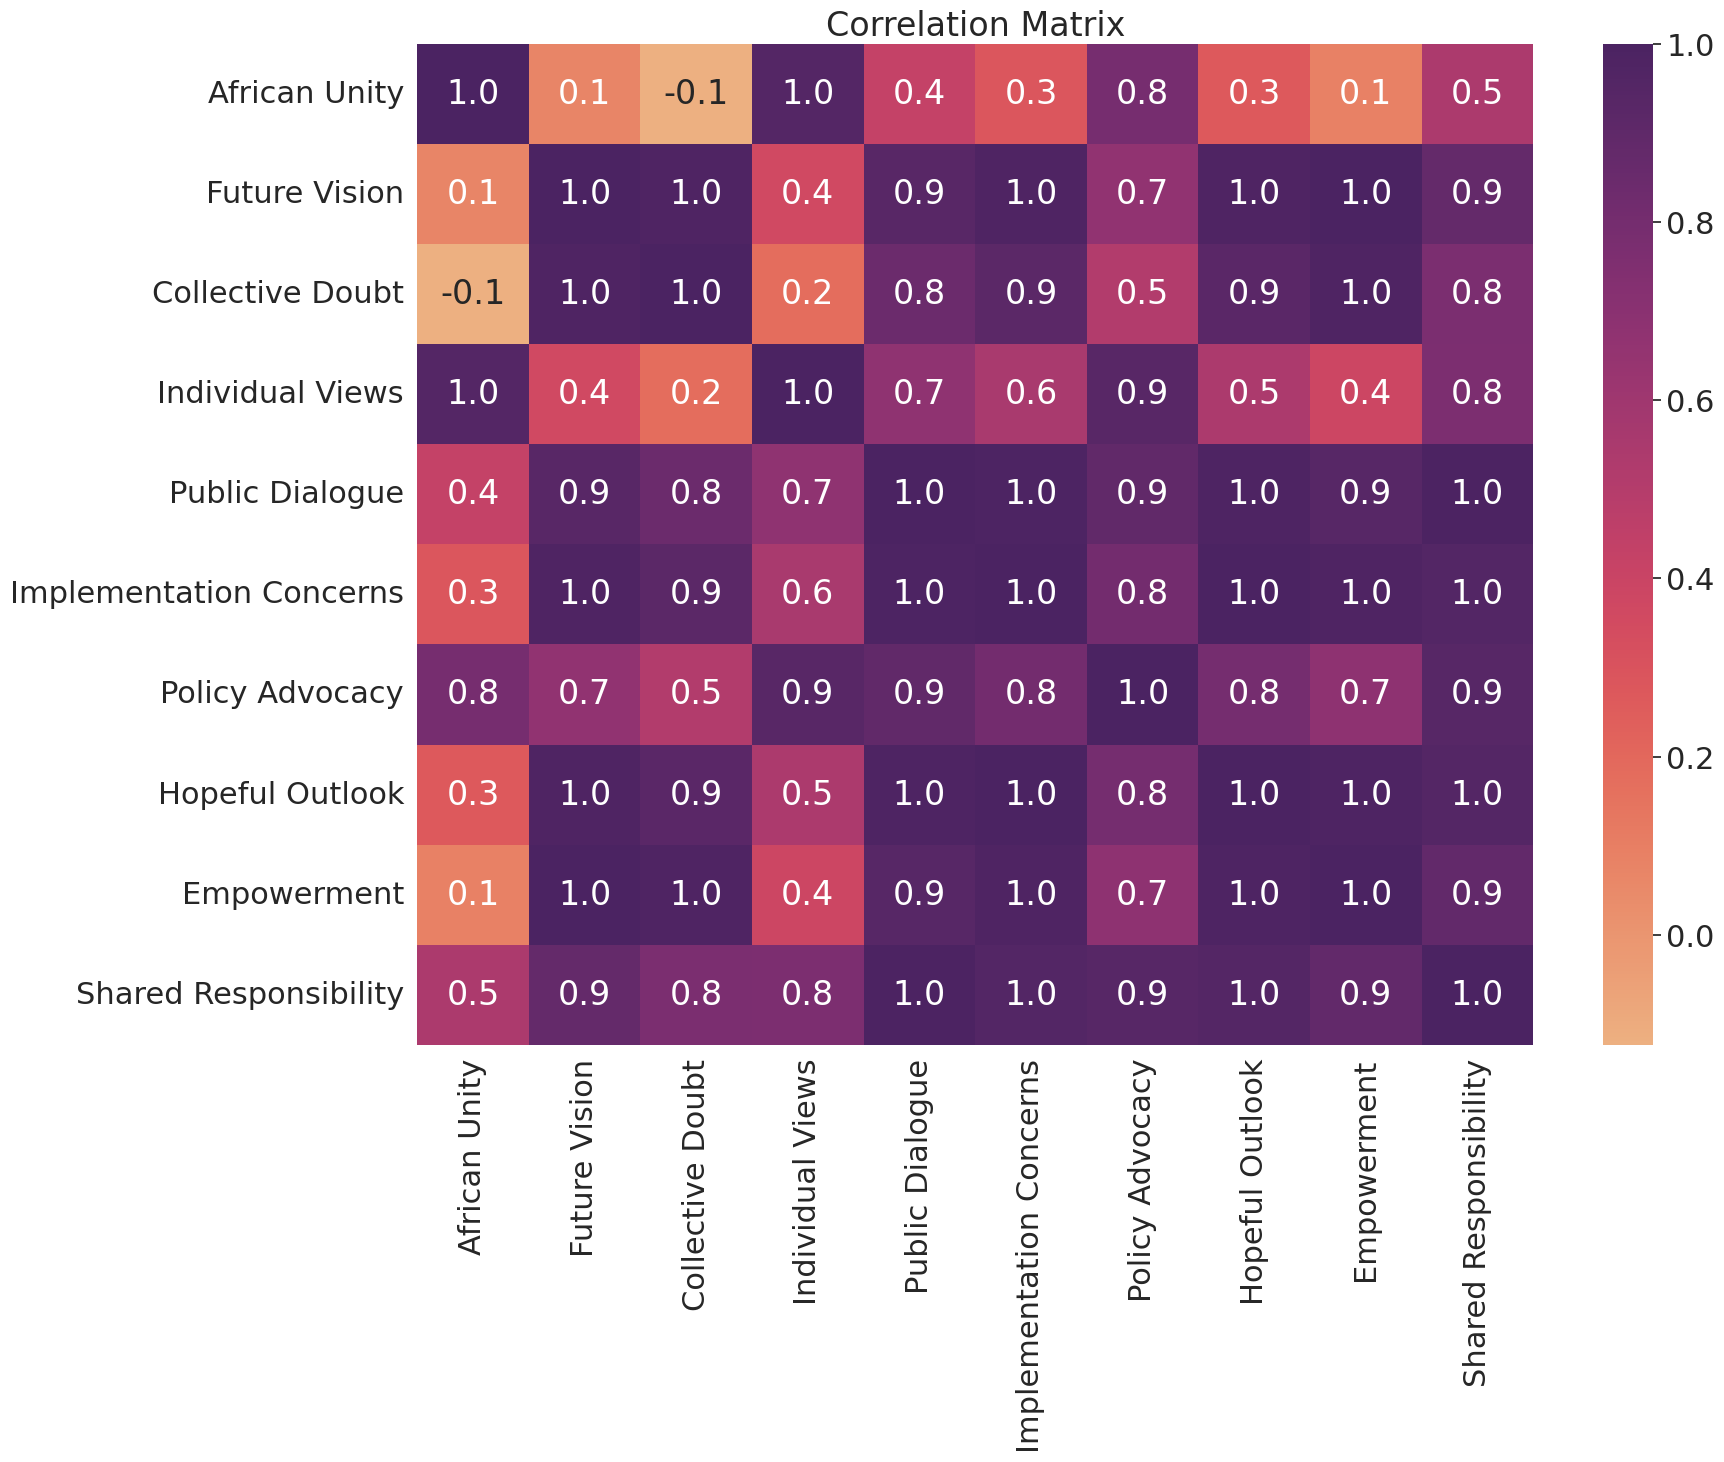

In [ ]:
# Define the data
#'African Unity',1: 'Future Vision', 2:'Collective Doubt', 3: 'Individual Views', 4:'Public Dialogue', 5:'Implementation Concerns', 6:'Policy Advocacy', 7:'Hopeful Outlook', 8:'Empowerment', 9:'Shared Responsibility
topic_names = [
    "African Unity",
    "Future Vision",
    "Collective Doubt",
    "Individual Views",
    "Public Dialogue",
    "Implementation Concerns",
    "Policy Advocacy",
    "Hopeful Outlook",
    "Empowerment",
    "Shared Responsibility",]

# Get the topic-polarity matrix
topic_polarity_matrix = df_topic_polarity.values

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(topic_polarity_matrix)
fig, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(correlation_matrix, annot=True, cmap="flare", fmt=".1f", xticklabels=topic_names, yticklabels=topic_names)
plt.title("Correlation Matrix")
plt.show()

###Plot dendongram chart for the topic identified

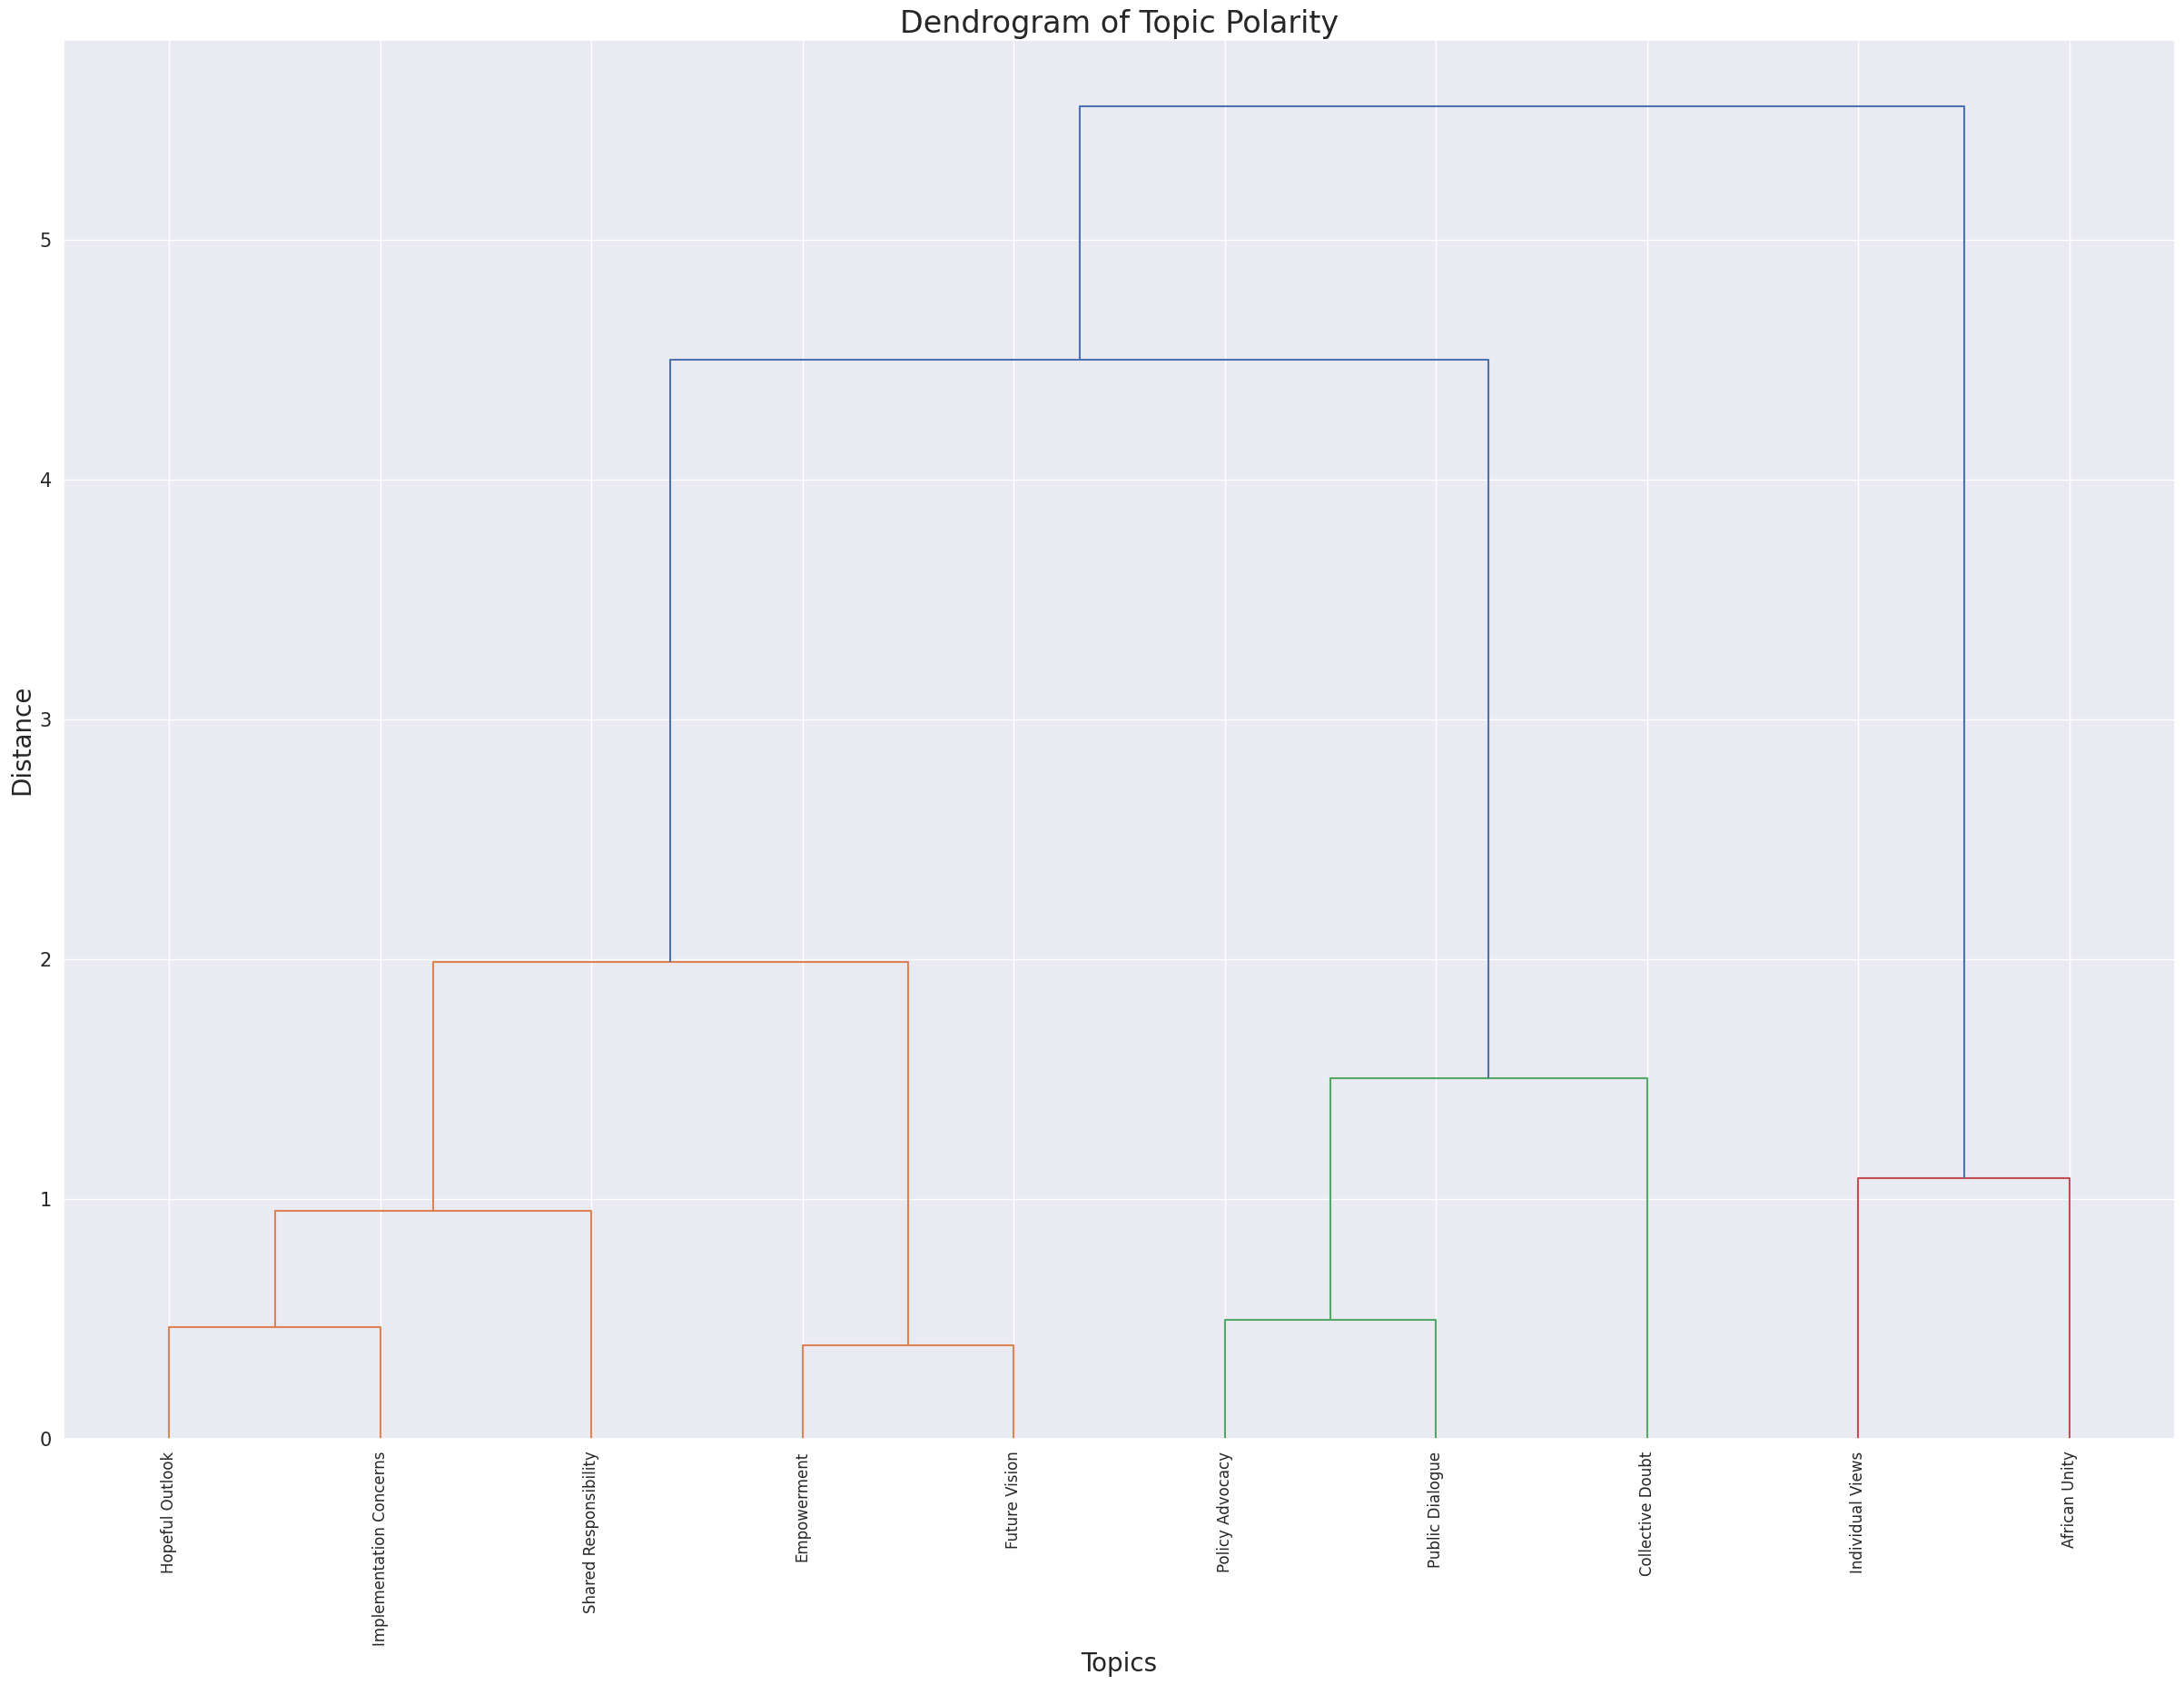

In [ ]:

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler

# Standardize the topic-polarity matrix
scaler = StandardScaler()
scaled_topic_polarity_matrix = scaler.fit_transform(topic_polarity_matrix)

# Calculate the linkage
linkage_matrix = sch.linkage(scaled_topic_polarity_matrix, method='ward')

# Create the dendrogram
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, orientation='top', distance_sort='descending', labels=topic_names)
plt.title('Dendrogram of Topic Polarity', size=24)
plt.xlabel('Topics', size=20)
plt.ylabel('Distance', size=20)
plt.tick_params(axis='x', rotation=90)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()


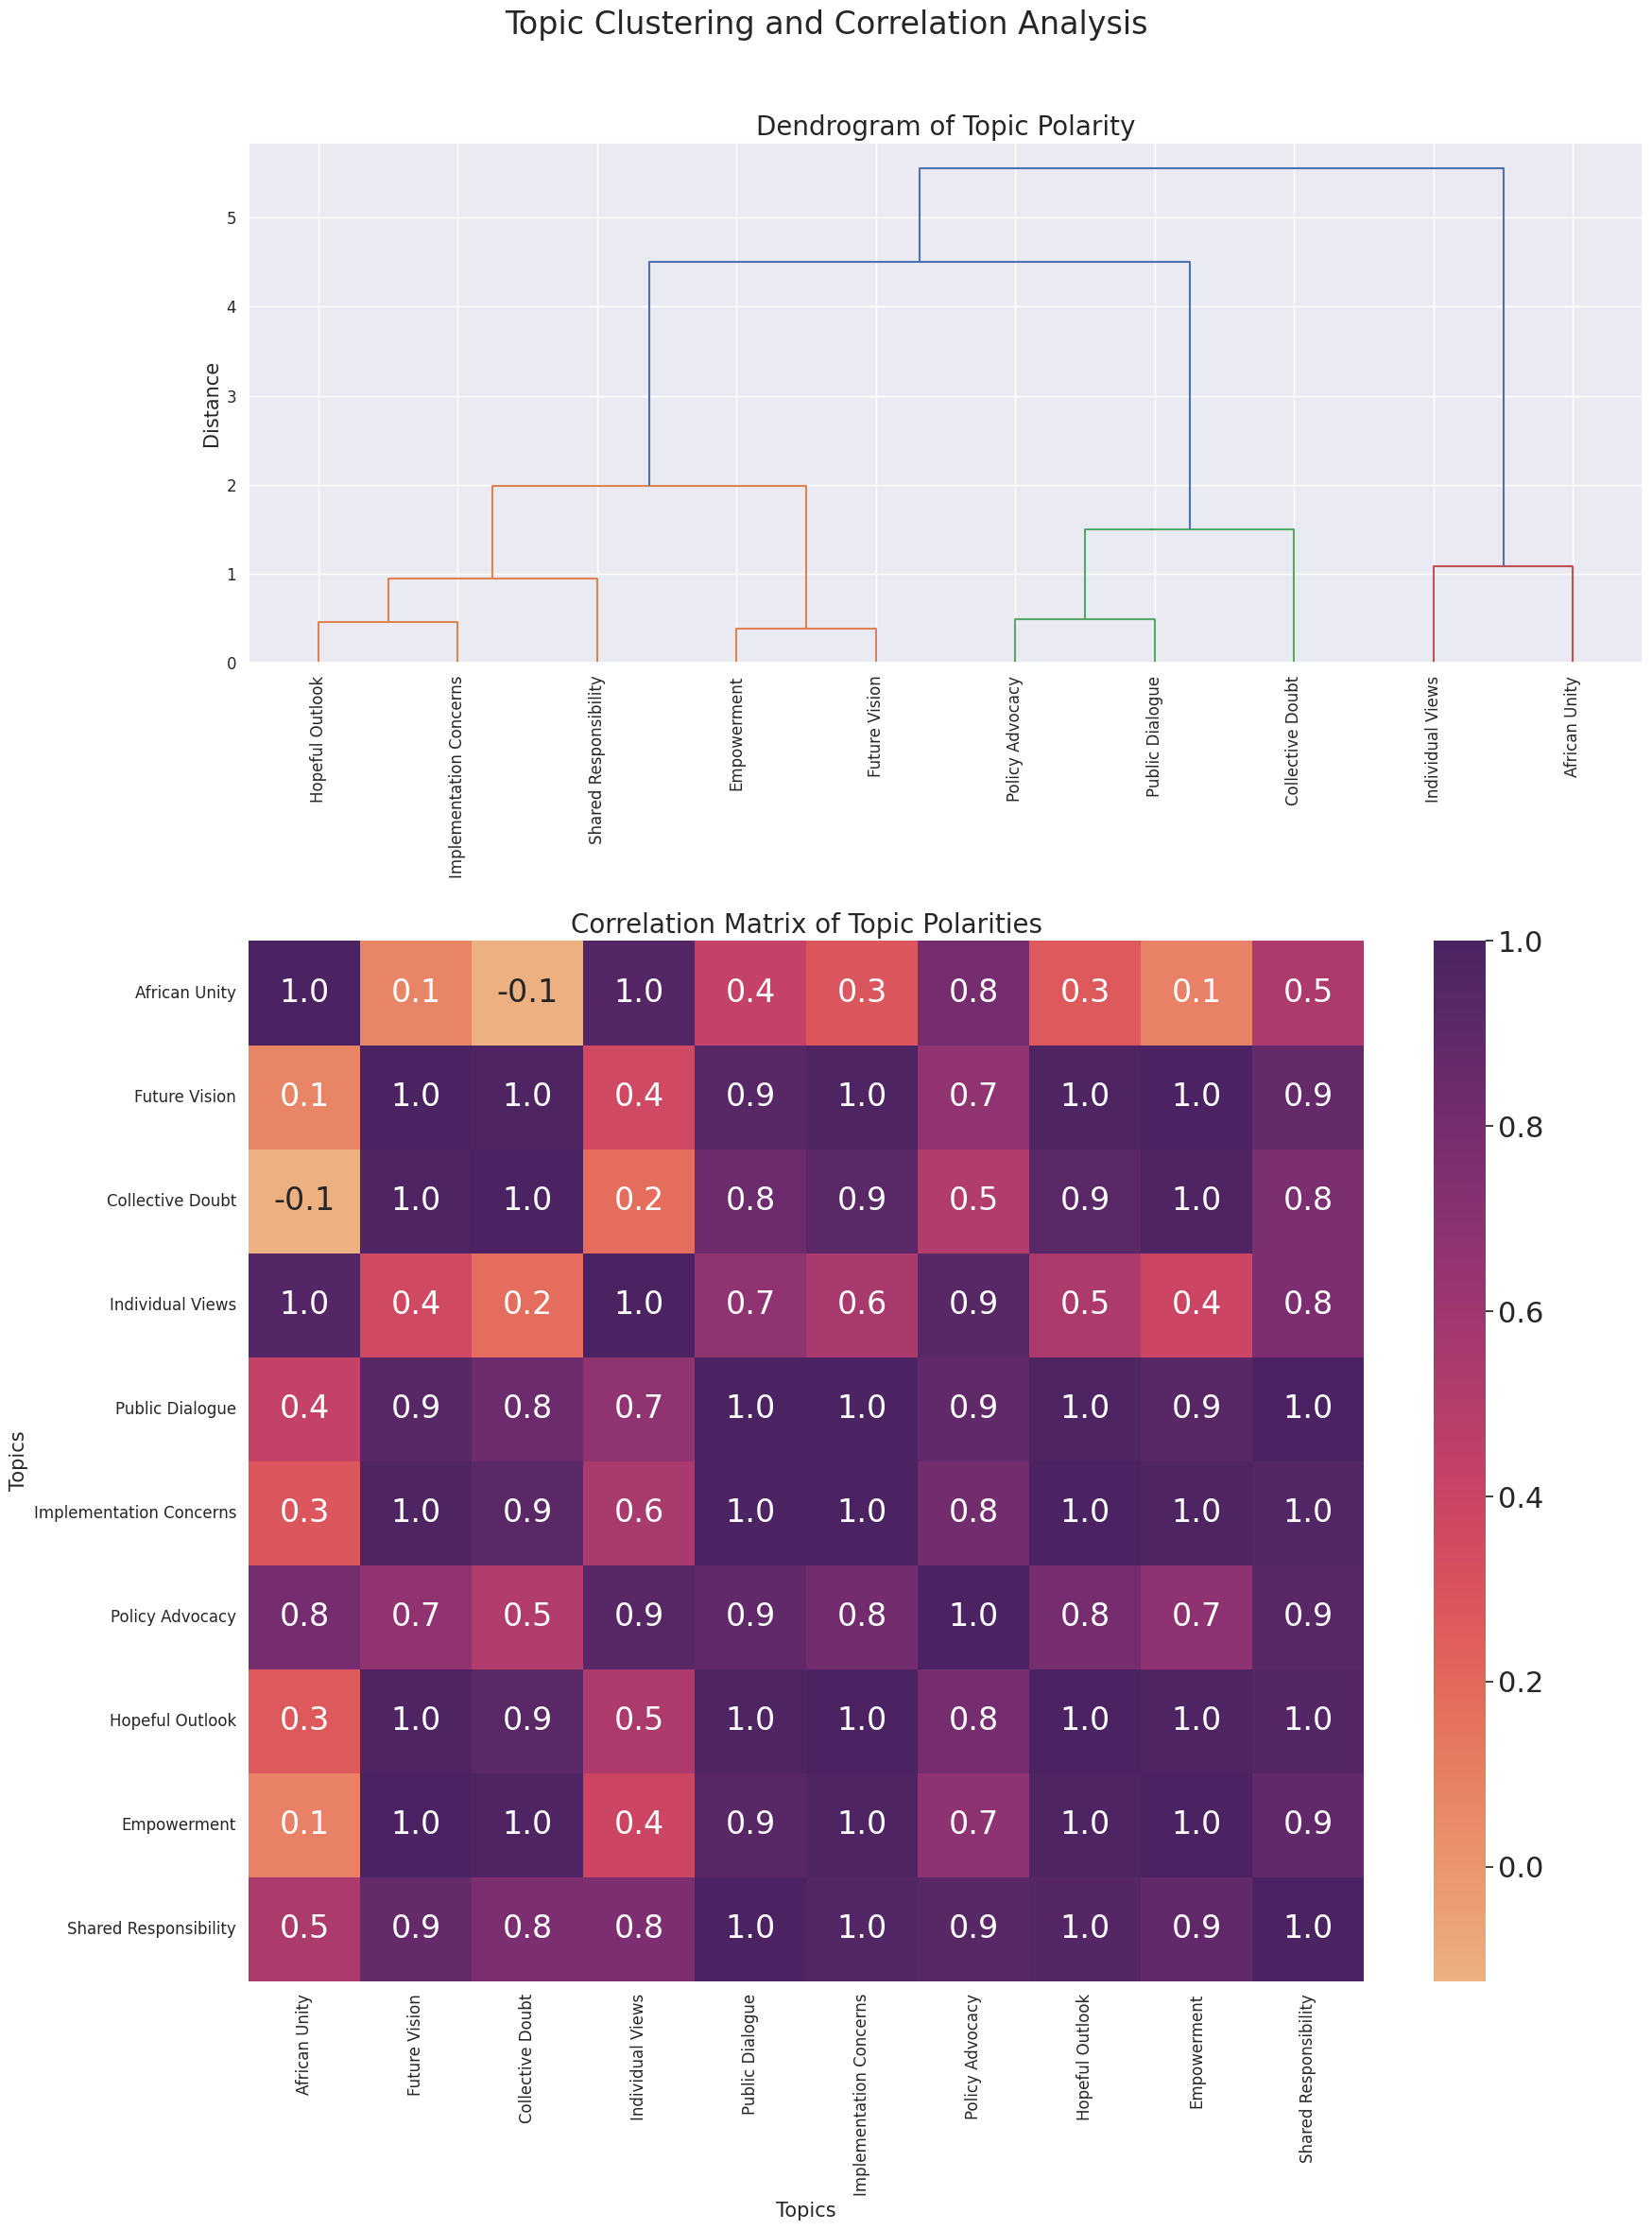

In [ ]:
# prompt: generate a code for puting the dendogram and corr matrix together

# Define topic names (should match the order of topics from LDA)
topic_names = [
    "African Unity",
    "Future Vision",
    "Collective Doubt",
    "Individual Views",
    "Public Dialogue",
    "Implementation Concerns",
    "Policy Advocacy",
    "Hopeful Outlook",
    "Empowerment",
    "Shared Responsibility",
]

# Create a new dataframe with topic names and polarity percentages
# This part was already in the original code, ensuring it's present.
df_topic_polarity = df_1.groupby('Topic')['Analysis_Polarity'].value_counts().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Get the topic-polarity matrix
topic_polarity_matrix = df_topic_polarity.values

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(topic_polarity_matrix)

# Standardize the topic-polarity matrix for dendrogram
scaler = StandardScaler()
scaled_topic_polarity_matrix = scaler.fit_transform(topic_polarity_matrix)

# Calculate the linkage for the dendrogram
linkage_matrix = sch.linkage(scaled_topic_polarity_matrix, method='ward')

# --- Plotting ---

# Create a figure with two subplots: one for the dendrogram, one for the heatmap
fig, (ax_dendrogram, ax_heatmap) = plt.subplots(2, 1, figsize=(18, 25), gridspec_kw={'height_ratios': [1, 2]})

# Plot the dendrogram
sch.dendrogram(linkage_matrix, orientation='top', distance_sort='descending', labels=topic_names, ax=ax_dendrogram)
ax_dendrogram.set_title('Dendrogram of Topic Polarity', size=20)
ax_dendrogram.set_ylabel('Distance', size=15)
ax_dendrogram.tick_params(axis='x', rotation=90, labelsize=12)
ax_dendrogram.tick_params(axis='y', which='major', labelsize=12)

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="flare", fmt=".1f",
            xticklabels=topic_names, yticklabels=topic_names, ax=ax_heatmap)
ax_heatmap.set_title("Correlation Matrix of Topic Polarities", size=20)
ax_heatmap.set_xlabel('Topics', size=15)
ax_heatmap.set_ylabel('Topics', size=15)
ax_heatmap.tick_params(axis='x', rotation=90, labelsize=12)
ax_heatmap.tick_params(axis='y', rotation=0, labelsize=12) # Keep y-labels horizontal

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap and make space for titles
fig.suptitle('Topic Clustering and Correlation Analysis', fontsize=24, y=0.98) # Add a main title
plt.show()

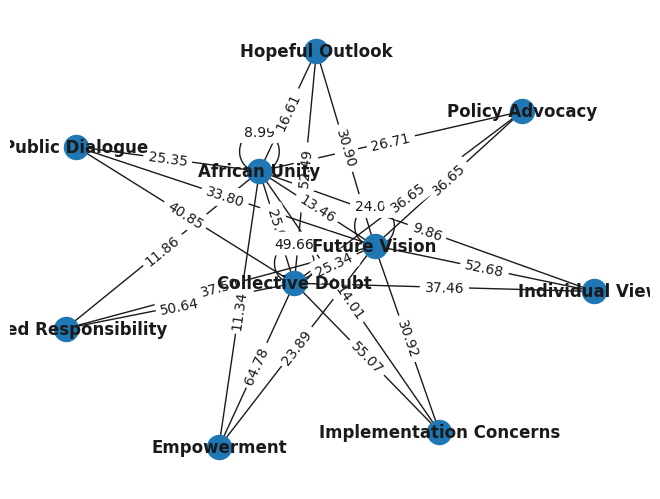

In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(topic_names)

# Add edges to the graph based on the polarity matrix
for i in range(len(topic_polarity_matrix)):
    for j in range(len(topic_polarity_matrix[0])):
        if topic_polarity_matrix[i][j] > 0.5:
            G.add_edge(topic_names[i], topic_names[j], weight=topic_polarity_matrix[i][j])

# Set the layout of the nodes
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_weight='bold')

# Set the edge labels
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


###Load libraries for Network Analysis

In [2]:
#Changing Colours
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(topic_names)

# Add edges to the graph based on the polarity matrix
for i in range(len(topic_polarity_matrix)):
    for j in range(len(topic_polarity_matrix[0])):
        if i != j and topic_polarity_matrix[i][j] > 0.5:  # Ensure not adding self-loops and filter by threshold
            G.add_edge(topic_names[i], topic_names[j], weight=topic_polarity_matrix[i][j])

# Set the layout of the nodes
pos = nx.spring_layout(G)

# Draw the graph with edge colors based on weight (polarity)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [plt.cm.coolwarm(weight) for weight in weights]

# Remove the 'edges' argument and let NetworkX handle it internally
nx.draw(G, pos, with_labels=True, font_weight='bold', edge_color=colors, node_color='Skyblue', node_size=2000, font_size=10)

# Set the edge labels
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

NameError: name 'topic_names' is not defined

###Check for the degree of centrality and betweenness for the topics identified

In [ ]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Print the results
print("Degree Centrality:")
for node, centrality in degree_centrality.items():
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")


Degree Centrality:
African Unity: 1.0
Future Vision: 1.0
Collective Doubt: 1.0
Individual Views: 0.3333333333333333
Public Dialogue: 0.3333333333333333
Implementation Concerns: 0.3333333333333333
Policy Advocacy: 0.3333333333333333
Hopeful Outlook: 0.3333333333333333
Empowerment: 0.3333333333333333
Shared Responsibility: 0.3333333333333333

Betweenness Centrality:
African Unity: 0.19444444444444442
Future Vision: 0.19444444444444442
Collective Doubt: 0.19444444444444442
Individual Views: 0.0
Public Dialogue: 0.0
Implementation Concerns: 0.0
Policy Advocacy: 0.0
Hopeful Outlook: 0.0
Empowerment: 0.0
Shared Responsibility: 0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

# Assuming 'Analysis_Polarity' is your target variable and other relevant features are in X
X = df[['Polarity', 'Subjectivity', 'Topic']]  # Example features, replace with your actual features
y = df['Analysis_Polarity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))


# Evaluate models
results = []
names = []
for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model: {name}, Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        results.append(accuracy)
        names.append(name)
    except Exception as e:  # Handle potential errors during model training/prediction
        print(f"Error with model {name}: {e}")
        results.append(0)
        names.append(name)


Model: LR, Accuracy: 0.9043151969981238
              precision    recall  f1-score   support

    Negative       1.00      0.71      0.83        82
     Neutral       0.86      0.91      0.89       209
    Positive       0.92      0.97      0.94       242

    accuracy                           0.90       533
   macro avg       0.93      0.86      0.89       533
weighted avg       0.91      0.90      0.90       533

Model: KNN, Accuracy: 0.9418386491557224
              precision    recall  f1-score   support

    Negative       0.84      0.88      0.86        82
     Neutral       0.96      0.93      0.94       209
    Positive       0.97      0.98      0.97       242

    accuracy                           0.94       533
   macro avg       0.92      0.93      0.92       533
weighted avg       0.94      0.94      0.94       533

Model: NB, Accuracy: 0.9587242026266416
              precision    recall  f1-score   support

    Negative       1.00      0.73      0.85        82
     Neu

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

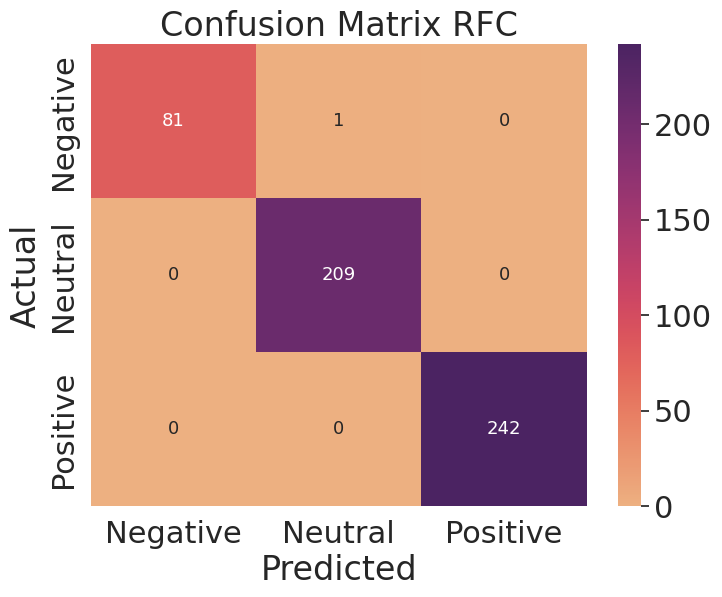

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            annot_kws={"size": 13})
plt.title("Confusion Matrix RFC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()